**Clustering**

In [94]:
import os
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent

DATA_PATH = PROJECT_ROOT / "data" / "processed" / "CDC_Diabetes_Dataset_clean.csv"
DATA_PATH_FEAT_A = PROJECT_ROOT / "data" / "processed" / "CDC_Diabetes_Dataset_feature_set_A.csv"

FIG_DIR = PROJECT_ROOT / "figures" / "results_clustering"
FIG_DIR.mkdir(parents=True, exist_ok=True)


print("Project root directory:", PROJECT_ROOT)
print("Data path exists:", DATA_PATH.exists())
assert DATA_PATH.exists(), f"Data file not found at {DATA_PATH}"
print("Figures directory:", FIG_DIR)

Project root directory: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk
Data path exists: True
Figures directory: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_clustering


In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.utils import resample


In [96]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

In [97]:
# ---------------------------------------
# Setup: imports, paths, utilities
# ---------------------------------------

def savefig(name: str):
    """
    Save the current matplotlib figure to the figures directory
    at publication-quality resolution.
    """
    plt.savefig(FIG_DIR / name, dpi=300, bbox_inches="tight")
    print(f"Figure saved: {FIG_DIR / name}")

In [98]:
# load data from csv
df_cdc_clean = pd.read_csv(DATA_PATH)
print("Data loaded successfully.")
print("Top 5 rows:")
#df_cdc_clean.head()

df_cdc_featA = pd.read_csv(DATA_PATH_FEAT_A)
print("Data loaded successfully.")
print("Top 5 rows:")
df_cdc_featA.head()




Data loaded successfully.
Top 5 rows:
Data loaded successfully.
Top 5 rows:


,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex,GenHlth,Age,Education,Income,BMI,MentHlth,PhysHlth,RiskFactorCount,BMI_PhysActivity,Age_HighBP,Log1p_MentHlth,Log1p_PhysHlth,Diabetes_binary,split
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,6.0,6.0,8.0,25.0,3.0,1.0,0.0,25.0,0.0,1.386294,0.693147,0,train
1,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,7.0,6.0,8.0,22.0,0.0,0.0,2.0,22.0,7.0,0.000000,0.000000,0,train
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,7.0,6.0,6.0,25.0,20.0,0.0,2.0,25.0,7.0,3.044522,0.000000,0,train
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,5.0,6.0,7.0,25.0,0.0,0.0,0.0,25.0,0.0,0.000000,0.000000,0,train
4,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,4.0,12.0,4.0,6.0,27.0,0.0,1.0,4.0,27.0,12.0,0.000000,0.693147,1,train


In [99]:
df_cdc_clean.describe()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,229781.000000,229781.000000,229781.000000,229781.000000,229781.00000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000
mean,0.325627,0.454441,0.441760,0.959535,28.68567,0.465661,0.044756,0.103216,0.733355,0.612966,0.794813,0.060710,0.946075,0.092810,2.601151,3.505373,4.675178,0.185507,0.439231,8.086582,4.980568,5.890383
std,0.724623,0.497921,0.496598,0.197047,6.78636,0.498821,0.206767,0.304241,0.442206,0.487073,0.403839,0.238798,0.225871,0.290167,1.064685,7.713725,9.046568,0.388709,0.496295,3.093809,0.992895,2.092477
min,0.000000,0.000000,0.000000,0.000000,12.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.00000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,6.000000
75%,0.000000,1.000000,1.000000,1.000000,32.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,4.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,2.000000,1.000000,1.000000,1.000000,98.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [100]:
# Create base dataset from the dataset used in classification
df_featA = df_cdc_featA.copy()

engineered_cols = [
    'RiskFactorCount', 
    'BMI_PhysActivity',
    "Age_HighBP",
    "Log1p_MentHlth",
    "Log1p_PhysHlth"
]

# Create base dataset (without engineered features
df_base = df_featA.drop(columns = [c for c in engineered_cols if c in df_featA.columns]).copy()

print("df_featA shape:", df_featA.shape)
print("df_base  shape:", df_base.shape)

# sanity check: split column should exist + proportions
print("\nSplit counts (featA):")
print(df_featA["split"].value_counts())

print("\nSplit counts (base):")
print(df_base["split"].value_counts())

# confirm engineered columns presence/absence
print("\nEngineered columns present in featA:", [c for c in engineered_cols if c in df_featA.columns])
print("Engineered columns present in base :", [c for c in engineered_cols if c in df_base.columns])

df_featA shape: (229781, 28)
df_base  shape: (229781, 23)

Split counts (featA):
split
train    160846
test      34468
eval      34467
Name: count, dtype: int64

Split counts (base):
split
train    160846
test      34468
eval      34467
Name: count, dtype: int64

Engineered columns present in featA: ['RiskFactorCount', 'BMI_PhysActivity', 'Age_HighBP', 'Log1p_MentHlth', 'Log1p_PhysHlth']
Engineered columns present in base : []


Feature set definitions are provided in the next code cell.

In [101]:
# ============================================================
# Feature set definitions (used across all clustering runs)
# ============================================================

# Target variable:
# Defined here for later INTERPRETATION only.
# not used as input to any clustering model.
TARGET = "Diabetes_binary"

feature_sets = {
    # A) "Health metrics / conditions"
    "A_health_conditions": [
        "HighBP", "HighChol", "CholCheck", "Stroke", "HeartDiseaseorAttack",
        "AnyHealthcare", "NoDocbcCost", "DiffWalk", "GenHlth"
    ],

    # B) "Lifestyle / behaviours"
    "B_lifestyle": [
        "Smoker", "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump"
    ],

    # C) "Socioeconomic"
    "C_socioeconomic": [
        "Education", "Income"
    ],

    # D) "Body composition / demographics core"
    "D_body_demo": [
        "BMI", "Age", "Sex"
    ],

    # E) "Mental + physical health days"
    "E_mental_physical_days": [
        "MentHlth", "PhysHlth"
    ],
}

In [102]:
# ============================================================
# Feature set definitions (used across all clustering runs)
# ============================================================

# Target variable:
# Defined here for later INTERPRETATION only.
# not used as input to any clustering model.
TARGET = "Diabetes_binary"

feature_sets = {
    # A) "Health metrics / conditions"
    "A_health_conditions": [
        "HighBP", "HighChol", "CholCheck", "Stroke", "HeartDiseaseorAttack",
        "AnyHealthcare", "NoDocbcCost", "DiffWalk", "GenHlth"
    ],

    # B) "Lifestyle / behaviours"
    "B_lifestyle": [
        "Smoker", "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump"
    ],

    # C) "Socioeconomic"
    "C_socioeconomic": [
        "Education", "Income"
    ],

    # D) "Body composition / demographics core"
    "D_body_demo": [
        "BMI", "Age", "Sex"
    ],

    # E) "Mental + physical health days"
    "E_mental_physical_days": [
        "MentHlth", "PhysHlth"
    ],
}

# ------------------------------------------------------------
# Sanity check: ensure all features exist in the base dataset
# ------------------------------------------------------------
DATA_FOR_CHECK = df_base

missing = {
    k: [c for c in cols if c not in DATA_FOR_CHECK.columns]
    for k, cols in feature_sets.items()
}
missing = {k: v for k, v in missing.items() if len(v) > 0}

print("Target present in dataset:", TARGET in DATA_FOR_CHECK.columns)
print("Defined feature sets:", list(feature_sets.keys()))
print("Any missing columns:", bool(missing))

if missing:
    for k, v in missing.items():
        print(f"{k} missing columns: {v}")

# Optional: show feature set sizes
for k, cols in feature_sets.items():
    print(f"{k}: {len(cols)} features")

Target present in dataset: True
Defined feature sets: ['A_health_conditions', 'B_lifestyle', 'C_socioeconomic', 'D_body_demo', 'E_mental_physical_days']
Any missing columns: False
A_health_conditions: 9 features
B_lifestyle: 5 features
C_socioeconomic: 2 features
D_body_demo: 3 features
E_mental_physical_days: 2 features





**Clustering Pipeline D**

In [103]:
# ==============================
# Define clustering view for feature set D
# ==============================

# Choose dataset (primary clustering on base features)
DF_CLUSTER = df_base

# Use TRAIN only (same split as classification)
df_train = DF_CLUSTER[DF_CLUSTER["split"] == "train"].copy()

# Choose feature set (from feature_sets dict defined above)
FEATURE_SET_NAME = "D_body_demo"
FEATURE_COLS = feature_sets[FEATURE_SET_NAME]

# Build raw clustering matrix (NO transforms yet)
X_train_raw = df_train[FEATURE_COLS].copy()

# Sanity checks
print("Dataset used        : df_base")
print("Rows used           : train only")
print("Feature set         :", FEATURE_SET_NAME)
print("Feature columns     :", FEATURE_COLS)
print("X_train_raw shape   :", X_train_raw.shape)
print("Missing values      :", int(X_train_raw.isna().sum().sum()))
print("Unique values       :", {c: int(X_train_raw[c].nunique()) for c in FEATURE_COLS})

Dataset used        : df_base
Rows used           : train only
Feature set         : D_body_demo
Feature columns     : ['BMI', 'Age', 'Sex']
X_train_raw shape   : (160846, 3)
Missing values      : 0
Unique values       : {'BMI': 82, 'Age': 13, 'Sex': 2}


Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_clustering/boxplot_outlier_check_D.png


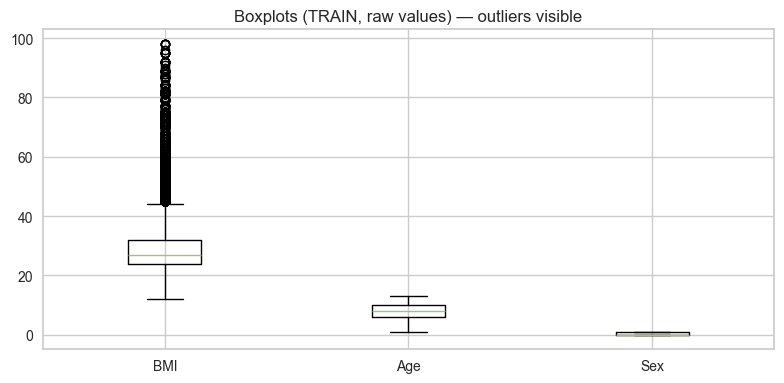

In [104]:
# confirm outliers in the dataset through boxplot, already observed in EDA
cols = FEATURE_COLS

plt.figure(figsize=(8,4))
plt.boxplot([df_train[c].values for c in cols], tick_labels=cols, showfliers=True)
plt.title("Boxplots (TRAIN, raw values) — outliers visible")
plt.tight_layout()
savefig("boxplot_outlier_check_D.png")
plt.show()


In [105]:
df_train[["BMI"]].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
BMI,160846.0,28.697792,6.780876,12.0,18.0,20.0,27.0,40.0,50.0,98.0


In [106]:
# Apply scaler to train data - fit on train only
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)

print("X_train_scaled shape:", X_train_scaled.shape)
print("Scaled median (approx 0):",  __import__("numpy").median(X_train_scaled, axis=0))
print("IQR (approx 1):", __import__("numpy").percentile(X_train_scaled, 75, axis=0) - __import__("numpy").percentile(X_train_scaled, 25, axis=0))

X_train_scaled shape: (160846, 3)
Scaled median (approx 0): [0. 0. 0.]
IQR (approx 1): [1. 1. 1.]


In [107]:
# PCA

pca = PCA(random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)

expl = pca.explained_variance_ratio_
cum  = np.cumsum(expl)

print("Explained variance ratio:", np.round(expl, 4))
print("Cumulative explained variance:", np.round(cum, 4))
print("X_train_pca shape:", X_train_pca.shape)

Explained variance ratio: [0.4656 0.3774 0.1571]
Cumulative explained variance: [0.4656 0.8429 1.    ]
X_train_pca shape: (160846, 3)


Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_clustering/pca_explained_variance_D.png


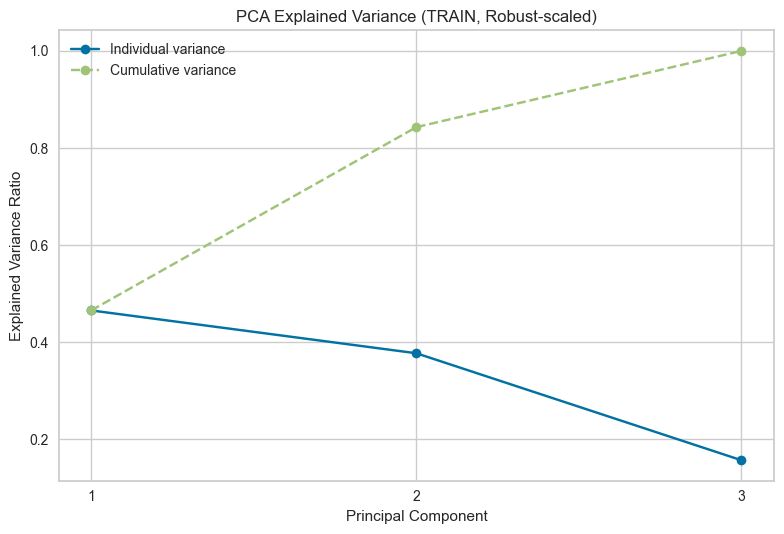

In [108]:
# plot PCA explained variance

explained = pca.explained_variance_ratio_
components = np.arange(1, len(explained) + 1)

plt.figure()
plt.plot(components, explained, marker="o", label="Individual variance")
plt.plot(components, np.cumsum(explained), marker="o", linestyle="--", label="Cumulative variance")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Explained Variance (TRAIN, Robust-scaled)")
plt.xticks(components)
plt.legend()
plt.tight_layout()
savefig("pca_explained_variance_D.png")
plt.show()

In [109]:
pca_2 = PCA(n_components=2, random_state=42)
X_train_pca_2 = pca_2.fit_transform(X_train_scaled)

print("X_train_pca_2 shape:", X_train_pca_2.shape)
print("Explained variance (2 PCs):", pca_2.explained_variance_ratio_)
print("Cumulative variance:", pca_2.explained_variance_ratio_.sum())

X_train_pca_2 shape: (160846, 2)
Explained variance (2 PCs): [0.46556164 0.37738517]
Cumulative variance: 0.8429468150662129


Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_clustering/pca_projection_D.png


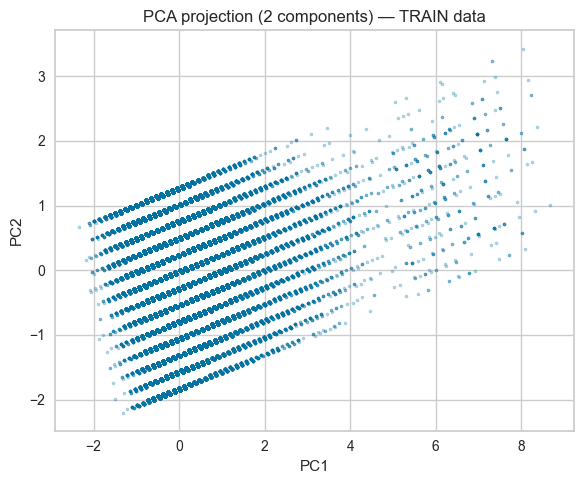

In [110]:
# Plot of PC1 vs PC2
plt.figure(figsize=(6,5))
plt.scatter(
    X_train_pca_2[:, 0],
    X_train_pca_2[:, 1],
    s=5,
    alpha=0.3
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection (2 components) — TRAIN data")
plt.tight_layout()
savefig("pca_projection_D.png")
plt.show()

k= 2 | inertia=142983.00
k= 3 | inertia=89919.51
k= 4 | inertia=72583.95
k= 5 | inertia=60257.86
k= 6 | inertia=50081.29
k= 7 | inertia=42231.12
k= 8 | inertia=37604.81
k= 9 | inertia=33331.98
k=10 | inertia=30082.37


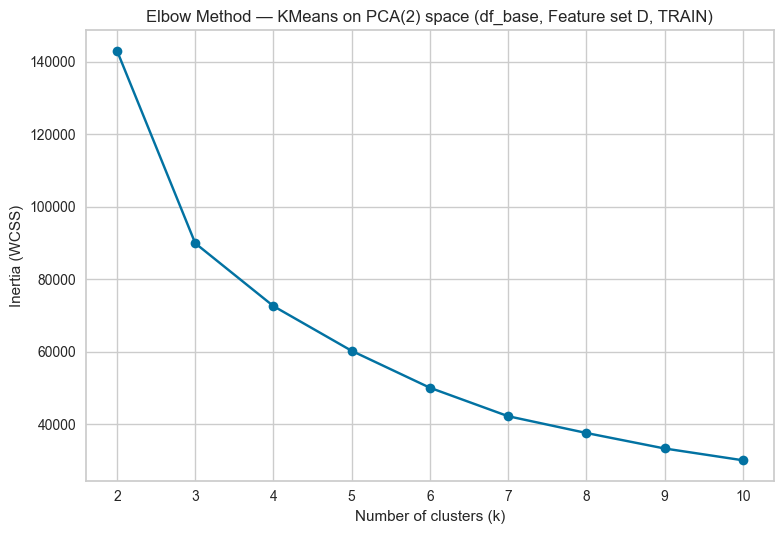

,k,inertia
0,2,142982.996595
1,3,89919.513552
2,4,72583.945753
3,5,60257.861027
4,6,50081.290961
5,7,42231.116841
6,8,37604.810992
7,9,33331.984263
8,10,30082.374594


In [111]:
# Elbow method

ks = list(range(2, 11))
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_train_pca_2)
    inertias.append(km.inertia_)
    print(f"k={k:2d} | inertia={km.inertia_:.2f}")

elbow_df = pd.DataFrame({"k": ks, "inertia": inertias})

plt.figure()
plt.plot(elbow_df["k"], elbow_df["inertia"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method — KMeans on PCA(2) space (df_base, Feature set D, TRAIN)")
plt.tight_layout()
plt.savefig(FIG_DIR / "kmeans_elbow_df_base_D.png", dpi=300)
plt.show()

elbow_df

k= 2 | silhouette(sample)=0.3468
k= 3 | silhouette(sample)=0.3941
k= 4 | silhouette(sample)=0.3558
k= 5 | silhouette(sample)=0.3422
k= 6 | silhouette(sample)=0.3536
k= 7 | silhouette(sample)=0.3574
k= 8 | silhouette(sample)=0.3403
k= 9 | silhouette(sample)=0.3300
k=10 | silhouette(sample)=0.3381


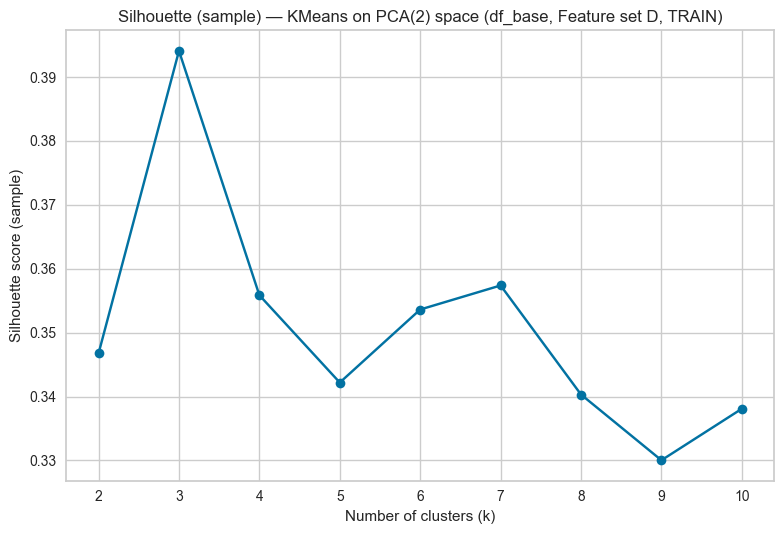

,k,silhouette_sample
0,2,0.346757
1,3,0.394091
2,4,0.355848
3,5,0.342183
4,6,0.353613
5,7,0.357379
6,8,0.340308
7,9,0.330022
8,10,0.338083


In [112]:
#Silhouette score

ks = list(range(2, 11))
sil_scores = []

# sample for speed
rng = np.random.RandomState(42)
sample_n = 20000 if X_train_pca_2.shape[0] > 20000 else X_train_pca_2.shape[0]
idx = rng.choice(X_train_pca_2.shape[0], size=sample_n, replace=False)
X_samp = X_train_pca_2[idx]

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_train_pca_2)

    sil = silhouette_score(X_samp, km.predict(X_samp))
    sil_scores.append(sil)
    print(f"k={k:2d} | silhouette(sample)={sil:.4f}")

sil_df = pd.DataFrame({"k": ks, "silhouette_sample": sil_scores})

plt.figure()
plt.plot(sil_df["k"], sil_df["silhouette_sample"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score (sample)")
plt.title("Silhouette (sample) — KMeans on PCA(2) space (df_base, Feature set D, TRAIN)")
plt.tight_layout()
plt.savefig(FIG_DIR / "kmeans_silhouette_df_base_D.png", dpi=300)
plt.show()

sil_df

K_FINAL: 3
Train cluster counts: {np.int32(0): np.int64(80799), np.int32(1): np.int64(30899), np.int32(2): np.int64(49148)}
Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_clustering/kmeans_clusters_df_base_D_k3_centroids.png


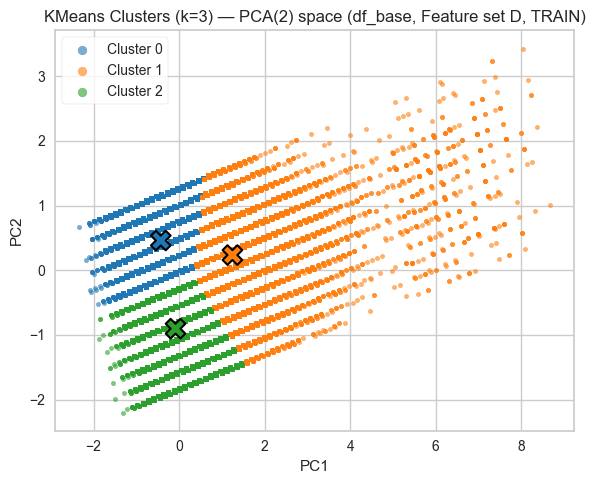

In [113]:
K_FINAL = 3

km_final = KMeans(n_clusters=K_FINAL, random_state=42, n_init=10)
train_clusters = km_final.fit_predict(X_train_pca_2)

print("K_FINAL:", K_FINAL)
print("Train cluster counts:", dict(zip(*np.unique(train_clusters, return_counts=True))))

centroids = km_final.cluster_centers_
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(6,5))

for k in range(K_FINAL):
    mask = train_clusters == k
    plt.scatter(
        X_train_pca_2[mask, 0],
        X_train_pca_2[mask, 1],
        s=10,
        alpha=0.6,
        color=cmap(k),
        label=f"Cluster {k}"
    )

# Centroids (X markers)
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="X",
    s=200,
    c=[cmap(i) for i in range(K_FINAL)],
    edgecolor="black",
    linewidths=1.5
)


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters (k=3) — PCA(2) space (df_base, Feature set D, TRAIN)")
plt.legend(markerscale=2, frameon=True)
plt.tight_layout()
savefig("kmeans_clusters_df_base_D_k3_centroids.png")
plt.show()

In [114]:
# Attach clusters to df_train
# profile clusteres in the original feature units
df_train_clusters = df_train.copy()
df_train_clusters["cluster"] = train_clusters

# Quick sanity check - how many records into each cluster?
print(df_train_clusters["cluster"].value_counts())

# C0 approx 50%, C2 30%, C1 20% (approx)
# no cluster is too small
# All clustes have good representation


cluster
0    80799
2    49148
1    30899
Name: count, dtype: int64


In [115]:
# profile each cluster using original variables
profile_cols = ["BMI", "Age", "Sex"]

cluster_profile = (
    df_train_clusters
    .groupby("cluster")[profile_cols]
    .agg(["mean", "median"])
    .round(2)
)

cluster_profile

# table results shows mean and median for each cluster
# understand characteristics for each cluster

BMI           Age          Sex       
          mean median   mean median  mean median
cluster                                         
0        26.34   26.0  10.31   10.0  0.43    0.0
1        38.83   37.0   7.70    8.0  0.42    0.0
2        26.20   26.0   4.68    5.0  0.46    0.0

In [116]:
# Bring Diabetes_binary back in for interpretation only
df_train_clusters["Diabetes_binary"] = df_featA.loc[df_train_clusters.index, "Diabetes_binary"]

diabetes_by_cluster = (
    df_train_clusters
    .groupby("cluster")["Diabetes_binary"]
    .mean()
    .round(3)
)
diabetes_by_cluster

# shows diabetes prevalence for each cluster
# used to understand which cluster is higher risk

cluster
0    0.188
1    0.313
2    0.059
Name: Diabetes_binary, dtype: float64

**Clustering Pipeline A**
- Most cells from clustering pipeline D will remain the same, except changing D-->A

In [117]:
# ==============================
# Define clustering view - feature set A
# ==============================

DF_CLUSTER = df_base
df_train_A = DF_CLUSTER[DF_CLUSTER["split"] == "train"].copy()

FEATURE_SET_NAME = "A_health_conditions"
FEATURE_COLS_A = feature_sets[FEATURE_SET_NAME]

X_train_raw_A = df_train[FEATURE_COLS_A].copy()

print("Dataset used        : df_base")
print("Rows used           : train only")
print("Feature set         :", FEATURE_SET_NAME)
print("Feature columns     :", FEATURE_COLS_A)
print("X_train_raw shape   :", X_train_raw_A.shape)
print("Missing values      :", int(X_train_raw_A.isna().sum().sum()))

Dataset used        : df_base
Rows used           : train only
Feature set         : A_health_conditions
Feature columns     : ['HighBP', 'HighChol', 'CholCheck', 'Stroke', 'HeartDiseaseorAttack', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'GenHlth']
X_train_raw shape   : (160846, 9)
Missing values      : 0


Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_clustering/boxplot_outlier_check_A.png


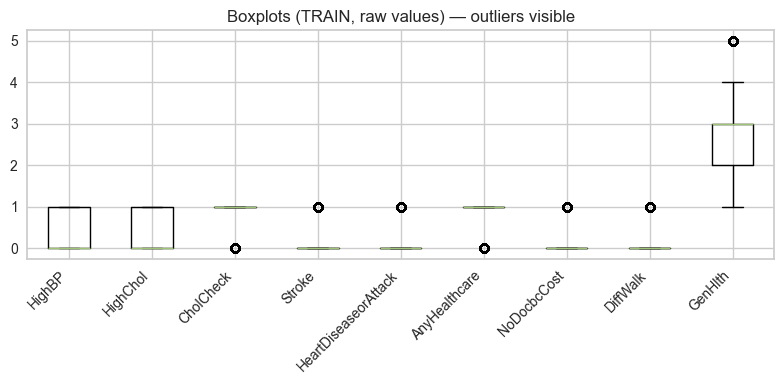

In [118]:
# confirm outliers in the dataset through boxplot, already observed in EDA
cols = FEATURE_COLS_A

plt.figure(figsize=(8,4))
plt.boxplot([df_train_A[c].values for c in cols], tick_labels=cols, showfliers=True)
plt.title("Boxplots (TRAIN, raw values) — outliers visible")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
savefig("boxplot_outlier_check_A.png")
plt.show()


In [119]:
summary_A = df_train_A[FEATURE_COLS_A].describe(
    percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]
).T
summary_A

,count,mean,std,min,1%,5%,50%,95%,99%,max
HighBP,160846.0,0.455858,0.498049,0.0,0.0,0.0,0.0,1.0,1.0,1.0
HighChol,160846.0,0.441988,0.496625,0.0,0.0,0.0,0.0,1.0,1.0,1.0
CholCheck,160846.0,0.960036,0.195875,0.0,0.0,1.0,1.0,1.0,1.0,1.0
Stroke,160846.0,0.044365,0.205906,0.0,0.0,0.0,0.0,0.0,1.0,1.0
HeartDiseaseorAttack,160846.0,0.103329,0.304389,0.0,0.0,0.0,0.0,1.0,1.0,1.0
AnyHealthcare,160846.0,0.945955,0.226108,0.0,0.0,0.0,1.0,1.0,1.0,1.0
NoDocbcCost,160846.0,0.092063,0.289116,0.0,0.0,0.0,0.0,1.0,1.0,1.0
DiffWalk,160846.0,0.186246,0.389307,0.0,0.0,0.0,0.0,1.0,1.0,1.0
GenHlth,160846.0,2.603179,1.065708,1.0,1.0,1.0,3.0,5.0,5.0,5.0


In [120]:
# Apply scaler to train data - fit on train only

scaler_A = RobustScaler()
X_train_scaled_A = scaler_A.fit_transform(X_train_raw_A)

print("X_train_scaled_A shape:", X_train_scaled_A.shape)
print("Scaled medians:", np.median(X_train_scaled_A, axis=0))
print("Scaled IQRs:", np.percentile(X_train_scaled_A, 75, axis=0) - np.percentile(X_train_scaled_A, 25, axis=0))

X_train_scaled_A shape: (160846, 9)
Scaled medians: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
Scaled IQRs: [1. 1. 0. 0. 0. 0. 0. 0. 1.]


Explained variance ratio (first 9): [0.5824 0.1378 0.0843 0.0566 0.042  0.0392 0.022  0.0185 0.0172]
Cumulative variance: [0.5824 0.7203 0.8046 0.8611 0.9031 0.9423 0.9643 0.9828 1.    ]
Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_clustering/pca_explained_variance_df_base_A.png


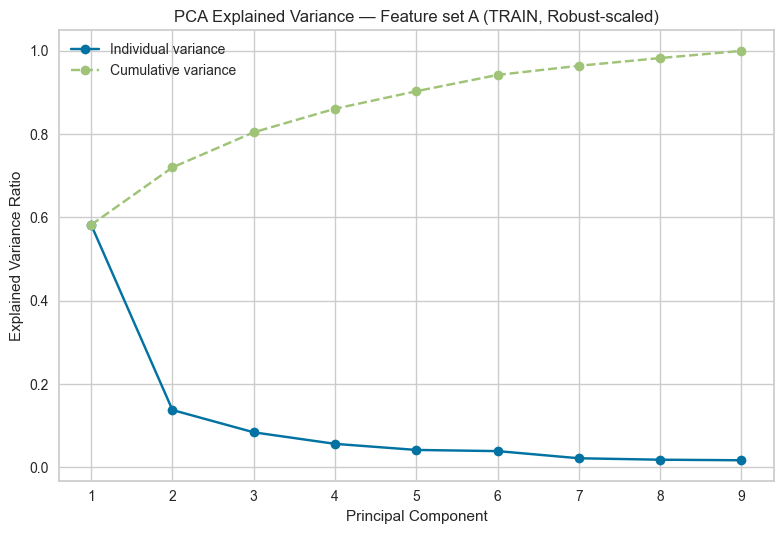

In [121]:
# PCA

pca_A = PCA(random_state=42)
X_train_pca_A = pca_A.fit_transform(X_train_scaled_A)

expl = pca_A.explained_variance_ratio_
cum = np.cumsum(expl)

print("Explained variance ratio (first 9):", np.round(expl, 4))
print("Cumulative variance:", np.round(cum, 4))

# Scree / cumulative plot
components = np.arange(1, len(expl) + 1)
plt.figure()
plt.plot(components, expl, marker="o", label="Individual variance")
plt.plot(components, cum, marker="o", linestyle="--", label="Cumulative variance")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Explained Variance — Feature set A (TRAIN, Robust-scaled)")
plt.xticks(components)
plt.legend()
plt.tight_layout()
savefig("pca_explained_variance_df_base_A.png")
plt.show()

X_train_pca_A2 shape: (160846, 2)
Explained variance (2 PCs): [0.58244929 0.13783358]
Cumulative variance: 0.7202828666731123


Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_clustering/pca_scatter_df_base_A_train.png


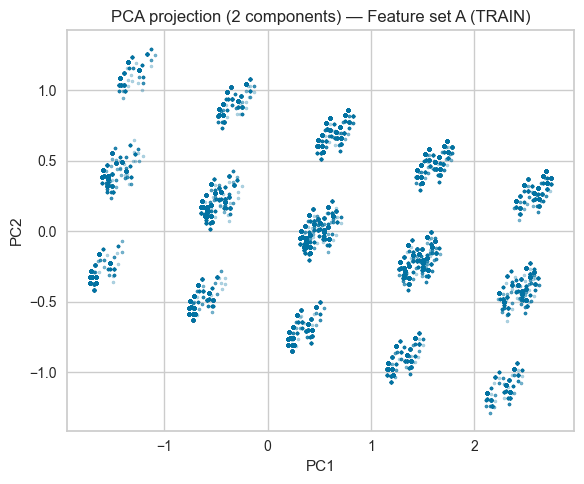

In [122]:
# PCA projection (PC1 vs PC2)

pca_A2 = PCA(n_components=2, random_state=42)
X_train_pca_A2 = pca_A2.fit_transform(X_train_scaled_A)

print("X_train_pca_A2 shape:", X_train_pca_A2.shape)
print("Explained variance (2 PCs):", pca_A2.explained_variance_ratio_)
print("Cumulative variance:", pca_A2.explained_variance_ratio_.sum())

plt.figure(figsize=(6,5))
plt.scatter(X_train_pca_A2[:,0], X_train_pca_A2[:,1], s=5, alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection (2 components) — Feature set A (TRAIN)")
plt.tight_layout()
savefig("pca_scatter_df_base_A_train.png")
plt.show()

k= 2 | inertia=107250.43
k= 3 | inertia=72407.21
k= 4 | inertia=54539.70
k= 5 | inertia=39226.31
k= 6 | inertia=30359.15
k= 7 | inertia=23243.38
k= 8 | inertia=18644.09
k= 9 | inertia=14276.76
k=10 | inertia=9830.56
Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_clustering/kmeans_elbow_df_base_A.png


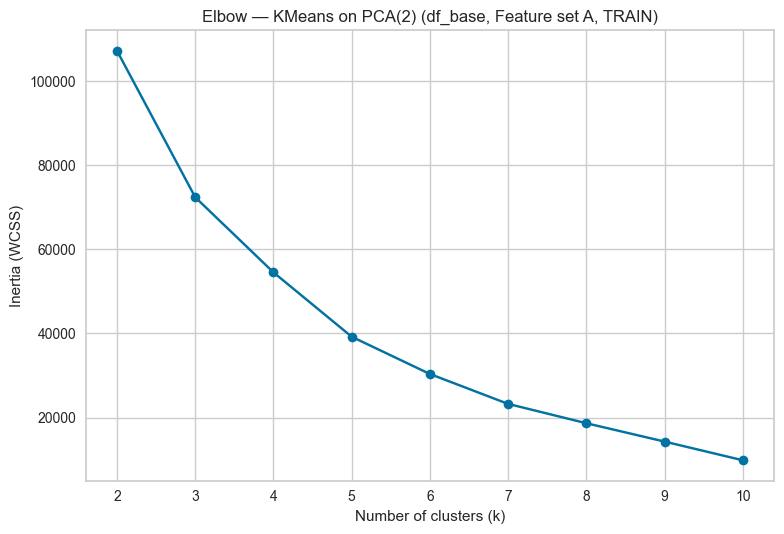

In [123]:
# Elbow method

ks = list(range(2, 11))
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_train_pca_A2)
    inertias.append(km.inertia_)
    print(f"k={k:2d} | inertia={km.inertia_:.2f}")

elbow_A_df = pd.DataFrame({"k": ks, "inertia": inertias})

plt.figure()
plt.plot(elbow_A_df["k"], elbow_A_df["inertia"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow — KMeans on PCA(2) (df_base, Feature set A, TRAIN)")
plt.tight_layout()
savefig( "kmeans_elbow_df_base_A.png")
plt.show()

k= 2 | silhouette(sample)=0.4899
k= 3 | silhouette(sample)=0.4614
k= 4 | silhouette(sample)=0.4802
k= 5 | silhouette(sample)=0.5423
k= 6 | silhouette(sample)=0.5708
k= 7 | silhouette(sample)=0.6019
k= 8 | silhouette(sample)=0.6310
k= 9 | silhouette(sample)=0.6936
k=10 | silhouette(sample)=0.7684
Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_clustering/kmeans_silhouette_df_base_A.png


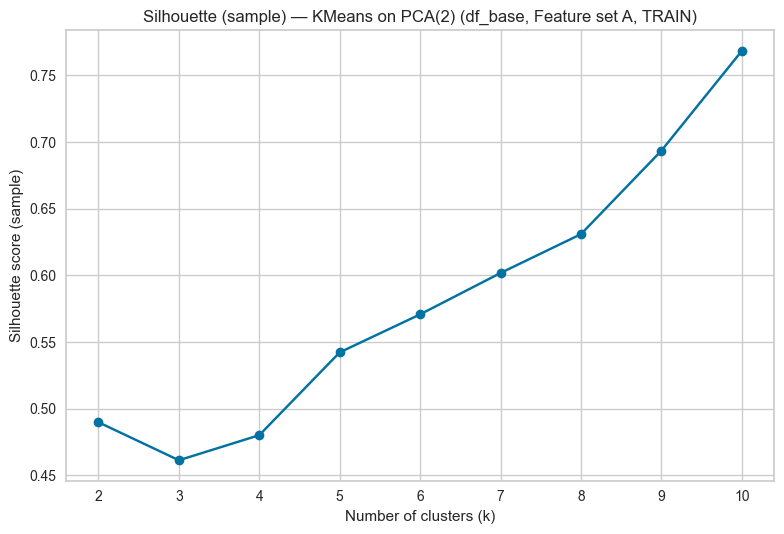

,k,silhouette_sample
0,2,0.489934
1,3,0.461428
2,4,0.480243
3,5,0.542334
4,6,0.570833
5,7,0.601857
6,8,0.630973
7,9,0.693581
8,10,0.768395


In [124]:
# Silhouette 


ks = list(range(2, 11))
sil_scores = []

# sample for speed
rng = np.random.RandomState(42)
sample_n = 20000 if X_train_pca_A2.shape[0] > 20000 else X_train_pca_A2.shape[0]
idx = rng.choice(X_train_pca_A2.shape[0], size=sample_n, replace=False)
X_samp = X_train_pca_A2[idx]

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_train_pca_A2)
    sil = silhouette_score(X_samp, km.predict(X_samp))
    sil_scores.append(sil)
    print(f"k={k:2d} | silhouette(sample)={sil:.4f}")

sil_A_df = pd.DataFrame({"k": ks, "silhouette_sample": sil_scores})

plt.figure()
plt.plot(sil_A_df["k"], sil_A_df["silhouette_sample"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score (sample)")
plt.title("Silhouette (sample) — KMeans on PCA(2) (df_base, Feature set A, TRAIN)")
plt.tight_layout()
savefig("kmeans_silhouette_df_base_A.png")
plt.show()

sil_A_df


K=3 cluster counts: {np.int32(0): np.int64(30682), np.int32(1): np.int64(78365), np.int32(2): np.int64(51799)}
Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_clustering/kmeans_clusters_df_base_A_k3_centroids.png


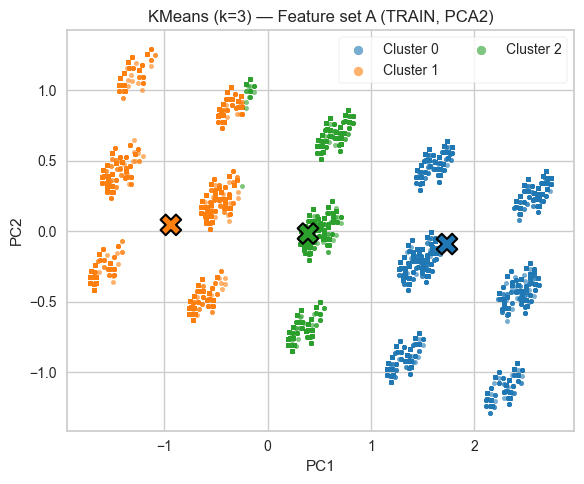


K=4 cluster counts: {np.int32(0): np.int64(37744), np.int32(1): np.int64(51583), np.int32(2): np.int64(30682), np.int32(3): np.int64(40837)}
Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_clustering/kmeans_clusters_df_base_A_k4_centroids.png


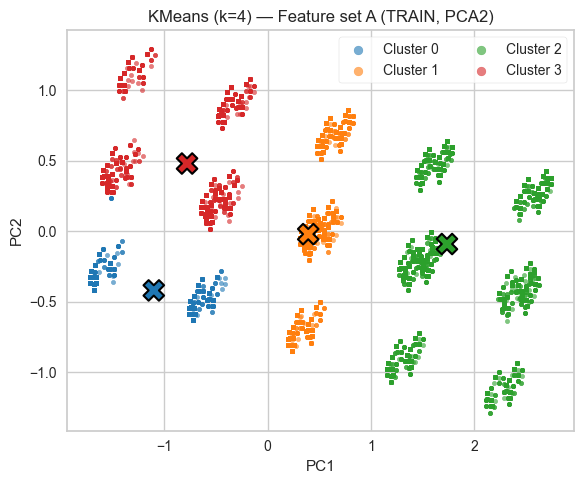


K=5 cluster counts: {np.int32(0): np.int64(27220), np.int32(1): np.int64(43056), np.int32(2): np.int64(27833), np.int32(3): np.int64(24421), np.int32(4): np.int64(38316)}
Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_clustering/kmeans_clusters_df_base_A_k5_centroids.png


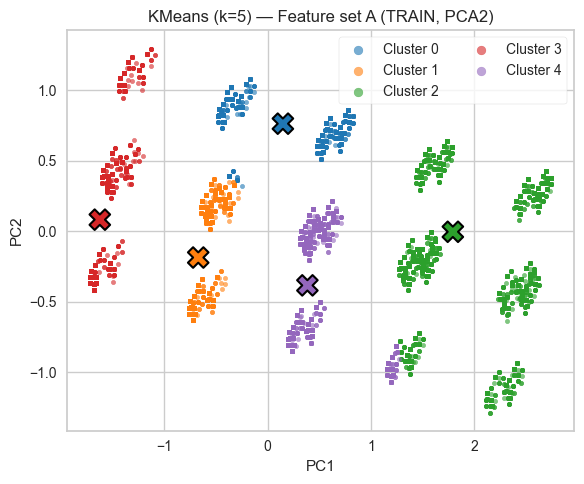

In [125]:

cmap = plt.get_cmap("tab10")
Ks_to_compare = [3, 4, 5]

for K in Ks_to_compare:
    km = KMeans(n_clusters=K, random_state=42, n_init=10)
    labels = km.fit_predict(X_train_pca_A2)
    centroids = km.cluster_centers_

    print(f"\nK={K} cluster counts:", dict(zip(*np.unique(labels, return_counts=True))))

    plt.figure(figsize=(6,5))
    for k in range(K):
        mask = labels == k
        plt.scatter(
            X_train_pca_A2[mask, 0],
            X_train_pca_A2[mask, 1],
            s=10, alpha=0.6,
            color=cmap(k),
            label=f"Cluster {k}"
        )

    # centroids
    plt.scatter(
        centroids[:, 0], centroids[:, 1],
        marker="X", s=220,
        c=[cmap(i) for i in range(K)],
        edgecolor="black", linewidths=1.5
    )
    

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"KMeans (k={K}) — Feature set A (TRAIN, PCA2)")
    plt.legend(markerscale=2, frameon=True, ncol=2)
    plt.tight_layout()
    savefig(f"kmeans_clusters_df_base_A_k{K}_centroids.png")
    plt.show()

In [126]:
# Comparison table for K = 3, 4, 5 using existing elbow/silhouette results
Ks_to_compare = [3, 4, 5]
rows = []

for K in Ks_to_compare:
    km = KMeans(n_clusters=K, random_state=42, n_init=10)
    labels = km.fit_predict(X_train_pca_A2)
    counts = dict(zip(*np.unique(labels, return_counts=True)))

    inertia = float(elbow_A_df.loc[elbow_A_df["k"] == K, "inertia"].iloc[0])
    sil = float(sil_A_df.loc[sil_A_df["k"] == K, "silhouette_sample"].iloc[0])

    rows.append({"K": K, "inertia": inertia, "silhouette_sample": sil, "counts": counts})

compare_A = pd.DataFrame(rows).sort_values("K")
compare_A

,K,inertia,silhouette_sample,counts
0,3,72407.212877,0.461428,"{0: 30682, 1: 78365, 2: 51799}"
1,4,54539.695307,0.480243,"{0: 37744, 1: 51583, 2: 30682, 3: 40837}"
2,5,39226.306986,0.542334,"{0: 27220, 1: 43056, 2: 27833, 3: 24421, 4: 38316}"


In [127]:
# Define final clusters for feature set A (K=4)
K_A = 4
km_A = KMeans(n_clusters=K_A, random_state=42, n_init=10)
clusters_A = km_A.fit_predict(X_train_pca_A2)

In [128]:
# Attach clusters to df_train
# profile clusteres in the original feature units
df_train_A_clusters = df_train_A.copy()
df_train_A_clusters["cluster_A"] = clusters_A

print(df_train_A_clusters["cluster_A"].value_counts())

# Profile health-condition features (means = prevalence for 0/1 vars)
profile_A = (
    df_train_A_clusters
    .groupby("cluster_A")[FEATURE_COLS_A]
    .mean()
    .round(3)
)

profile_A

cluster_A
1    51583
3    40837
0    37744
2    30682
Name: count, dtype: int64


,HighBP,HighChol,CholCheck,Stroke,HeartDiseaseorAttack,AnyHealthcare,NoDocbcCost,DiffWalk,GenHlth
cluster_A,,,,,,,,,
0,0.000,0.000,0.919,0.009,0.018,0.935,0.068,0.032,1.622
1,0.516,0.481,0.966,0.042,0.105,0.942,0.094,0.174,3.000
2,0.664,0.585,0.978,0.115,0.249,0.935,0.177,0.544,4.277
3,0.644,0.694,0.977,0.028,0.071,0.969,0.048,0.075,1.751


In [129]:
# Add target back in for interpretation only (from df_featA)
df_train_A_clusters[TARGET] = df_featA.loc[df_train_A_clusters.index, TARGET]

diabetes_by_cluster_A = (
    df_train_A_clusters
    .groupby("cluster_A")[TARGET]
    .mean()
    .round(3)
)

diabetes_by_cluster_A

cluster_A
0    0.031
1    0.204
2    0.361
3    0.123
Name: Diabetes_binary, dtype: float64

**Clustering pipeline B, C, E**

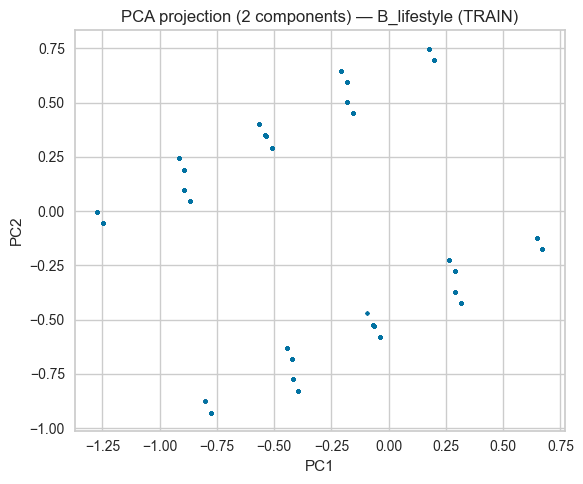

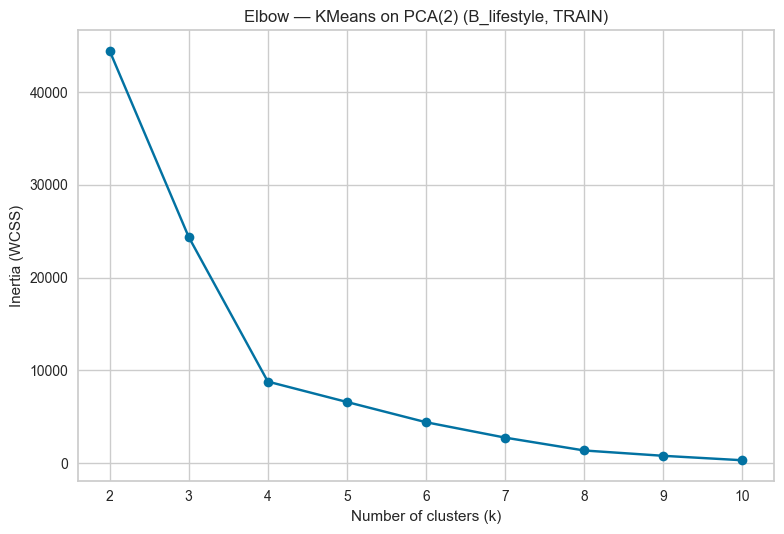

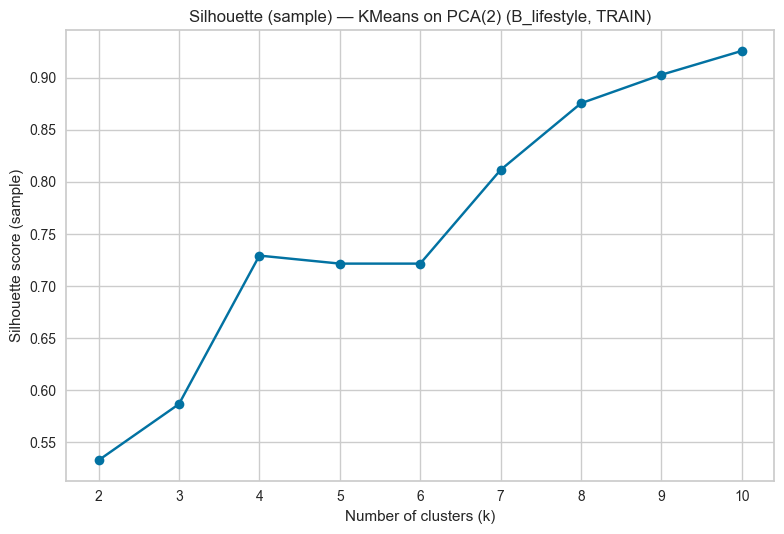


[B_lifestyle] PCA(2) cumulative variance: 0.584
[B_lifestyle] Auto K (max 6): 4
[B_lifestyle] Best silhouette within cap: 0.729


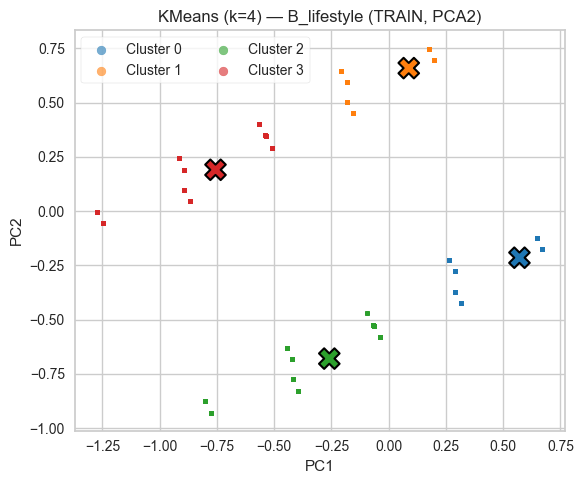

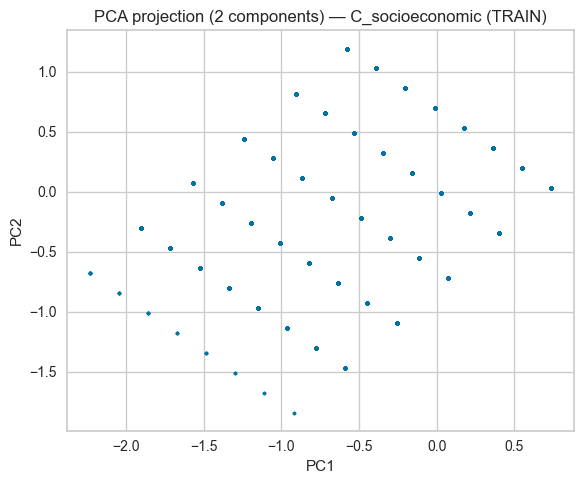

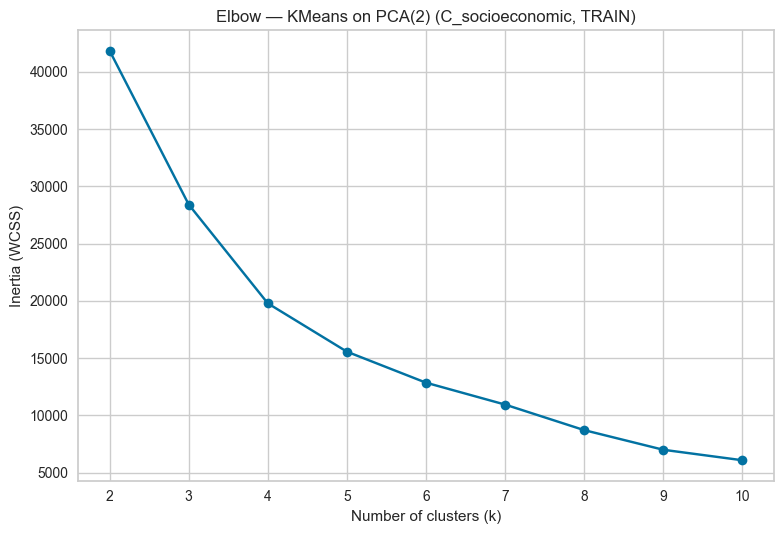

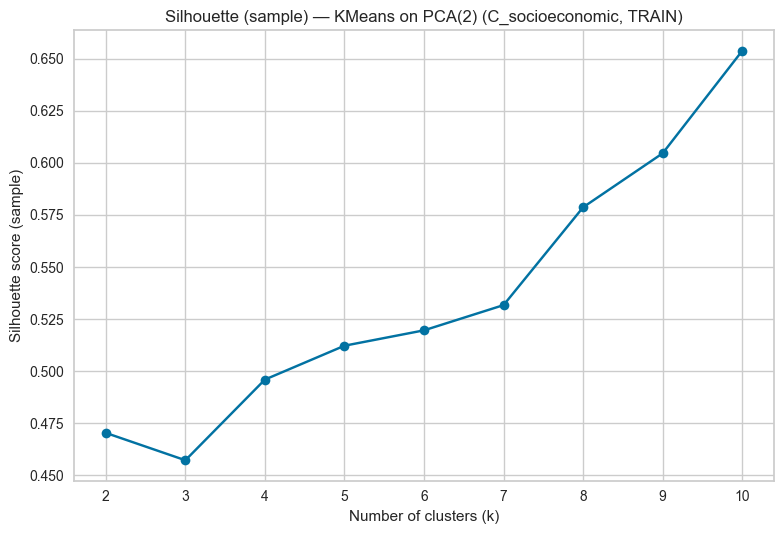


[C_socioeconomic] PCA(2) cumulative variance: 1.000
[C_socioeconomic] Auto K (max 6): 6
[C_socioeconomic] Best silhouette within cap: 0.520


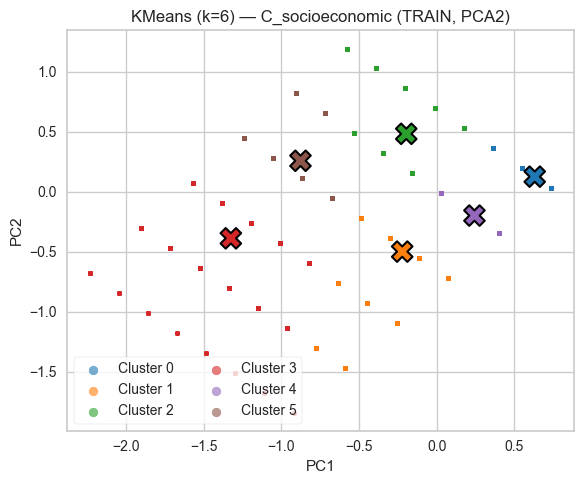

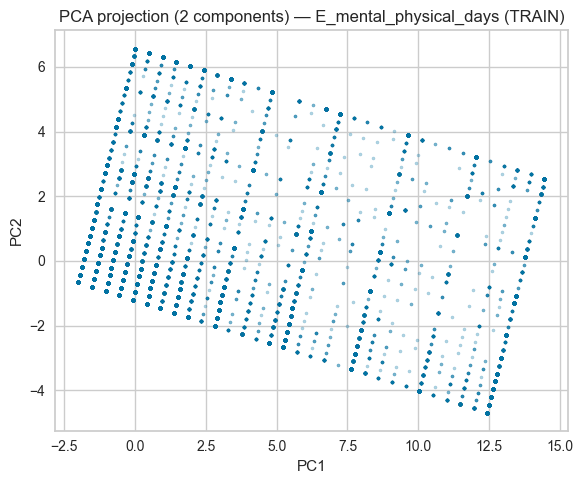

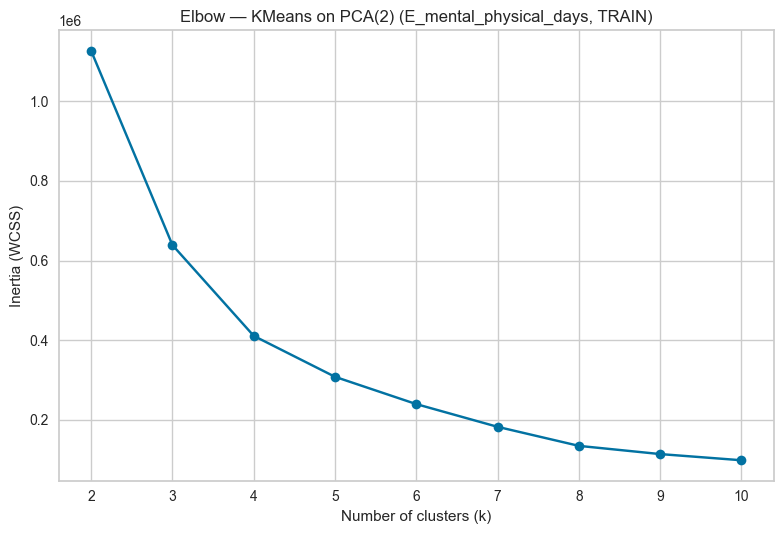

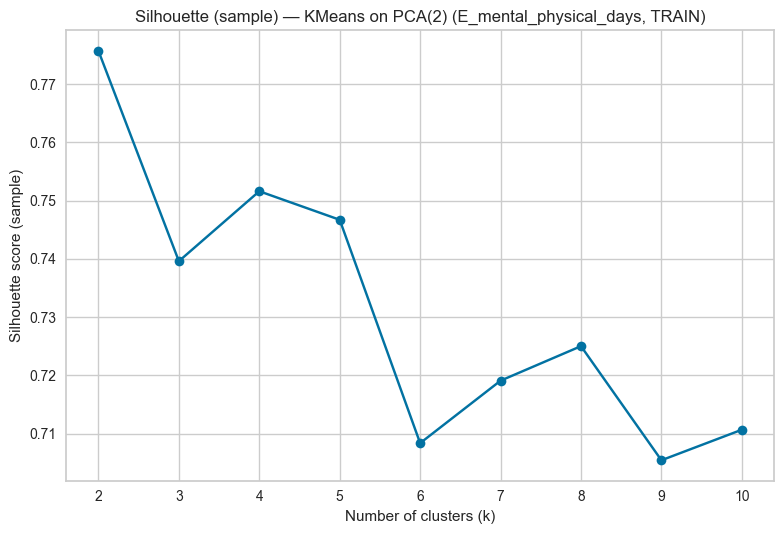


[E_mental_physical_days] PCA(2) cumulative variance: 1.000
[E_mental_physical_days] Auto K (max 6): 2
[E_mental_physical_days] Best silhouette within cap: 0.776


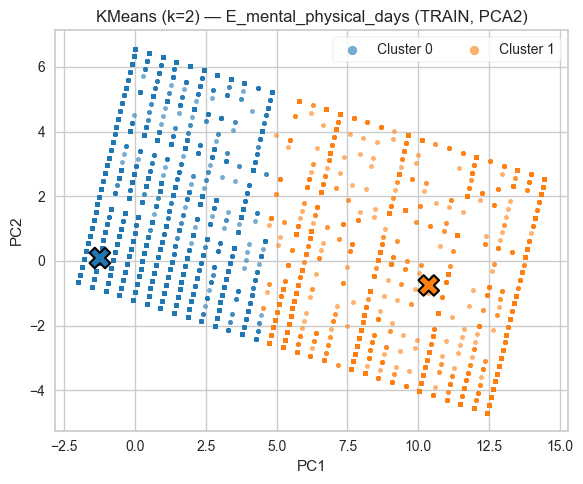


=== B_lifestyle ===
k_final: 4
cluster_counts: {0: 52877, 1: 41531, 3: 33548, 2: 32890}
diabetes_prevalence:
 cluster_B_lifestyle
0    0.147
1    0.180
2    0.173
3    0.205
Name: Diabetes_binary, dtype: float64

=== C_socioeconomic ===
k_final: 6
cluster_counts: {0: 51187, 4: 28889, 1: 28661, 2: 24025, 5: 20055, 3: 8029}
diabetes_prevalence:
 cluster_C_socioeconomic
0    0.121
1    0.168
2    0.203
3    0.310
4    0.146
5    0.260
Name: Diabetes_binary, dtype: float64

=== E_mental_physical_days ===
k_final: 2
cluster_counts: {0: 143604, 1: 17242}
diabetes_prevalence:
 cluster_E_mental_physical_days
0    0.165
1    0.239
Name: Diabetes_binary, dtype: float64


In [130]:
# --- Settings ---
APP_SETS = ["B_lifestyle", "C_socioeconomic", "E_mental_physical_days"]
KS = list(range(2, 11))
SIL_SAMPLE_N = 20000
RANDOM_STATE = 42

def run_feature_set_appendix(fs_name, fit_final=True, max_k_auto=6):
    """
    Runs: train-only -> RobustScaler -> PCA(2) -> elbow + silhouette(sample) -> auto-pick k
    Optionally fits final KMeans and outputs profiling tables + diabetes prevalence.
    """
    # 1) View
    DF_CLUSTER = df_base
    df_train_fs = DF_CLUSTER[DF_CLUSTER["split"] == "train"].copy()

    cols = feature_sets[fs_name]
    X_raw = df_train_fs[cols].copy()

    # Basic checks
    miss = int(X_raw.isna().sum().sum())
    if miss != 0:
        raise ValueError(f"{fs_name}: missing values found ({miss}). Handle before clustering.")

    # 2) Scale
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X_raw)

    # 3) PCA(2) (or 2D if only 2 features)
    n_pca = min(2, X_scaled.shape[1])
    pca = PCA(n_components=n_pca, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X_scaled)

    # Save PCA scatter (optional but useful)
    plt.figure(figsize=(6,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], s=5, alpha=0.3)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"PCA projection (2 components) — {fs_name} (TRAIN)")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"pca_scatter_df_base_{fs_name}_train.png", dpi=300)
    plt.show()

    # 4) Elbow (inertia)
    inertias = []
    for k in KS:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        km.fit(X_pca)
        inertias.append(km.inertia_)

    elbow_df = pd.DataFrame({"k": KS, "inertia": inertias})
    plt.figure()
    plt.plot(elbow_df["k"], elbow_df["inertia"], marker="o")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (WCSS)")
    plt.title(f"Elbow — KMeans on PCA(2) ({fs_name}, TRAIN)")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"kmeans_elbow_df_base_{fs_name}.png", dpi=300)
    plt.show()

    # 5) Silhouette (sample)
    rng = np.random.RandomState(RANDOM_STATE)
    n = X_pca.shape[0]
    sample_n = SIL_SAMPLE_N if n > SIL_SAMPLE_N else n
    idx = rng.choice(n, size=sample_n, replace=False)
    X_samp = X_pca[idx]

    sils = []
    for k in KS:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        km.fit(X_pca)
        sil = silhouette_score(X_samp, km.predict(X_samp))
        sils.append(sil)

    sil_df = pd.DataFrame({"k": KS, "silhouette_sample": sils})
    plt.figure()
    plt.plot(sil_df["k"], sil_df["silhouette_sample"], marker="o")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette score (sample)")
    plt.title(f"Silhouette (sample) — KMeans on PCA(2) ({fs_name}, TRAIN)")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"kmeans_silhouette_df_base_{fs_name}.png", dpi=300)
    plt.show()

    # 6) Choose K (appendix heuristic)
    # We cap k to avoid over-segmentation in appendix.
    sil_df_cap = sil_df[sil_df["k"] <= max_k_auto]
    k_auto = int(sil_df_cap.loc[sil_df_cap["silhouette_sample"].idxmax(), "k"])

    print(f"\n[{fs_name}] PCA(2) cumulative variance: {pca.explained_variance_ratio_.sum():.3f}")
    print(f"[{fs_name}] Auto K (max {max_k_auto}): {k_auto}")
    print(f"[{fs_name}] Best silhouette within cap: {sil_df_cap['silhouette_sample'].max():.3f}")

    outputs = {
        "fs_name": fs_name,
        "cols": cols,
        "pca_cumvar": float(pca.explained_variance_ratio_.sum()),
        "elbow_df": elbow_df,
        "sil_df": sil_df,
        "k_auto": k_auto,
    }

    if not fit_final:
        return outputs

    # 7) Fit final KMeans + plot + centroids
    km_final = KMeans(n_clusters=k_auto, random_state=RANDOM_STATE, n_init=10)
    labels = km_final.fit_predict(X_pca)
    centroids = km_final.cluster_centers_
    cmap = plt.get_cmap("tab10")

    plt.figure(figsize=(6,5))
    for k in range(k_auto):
        m = labels == k
        plt.scatter(X_pca[m,0], X_pca[m,1], s=10, alpha=0.6, color=cmap(k), label=f"Cluster {k}")
    plt.scatter(centroids[:,0], centroids[:,1], marker="X", s=220,
                c=[cmap(i) for i in range(k_auto)], edgecolor="black", linewidths=1.5)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.title(f"KMeans (k={k_auto}) — {fs_name} (TRAIN, PCA2)")
    plt.legend(markerscale=2, frameon=True, ncol=2)
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"kmeans_clusters_df_base_{fs_name}_k{k_auto}_centroids.png", dpi=300)
    plt.show()

    # 8) Profile in original feature space (means; for binary -> prevalence)
    df_train_out = df_train_fs.copy()
    df_train_out[f"cluster_{fs_name}"] = labels
    profile = df_train_out.groupby(f"cluster_{fs_name}")[cols].mean().round(3)

    # 9) Diabetes prevalence (interpretation only)
    if TARGET in df_featA.columns:
        df_train_out[TARGET] = df_featA.loc[df_train_out.index, TARGET]
        diab = df_train_out.groupby(f"cluster_{fs_name}")[TARGET].mean().round(3)
    else:
        diab = None

    outputs.update({
        "k_final": k_auto,
        "profile": profile,
        "diabetes_prevalence": diab,
        "cluster_counts": df_train_out[f"cluster_{fs_name}"].value_counts().to_dict()
    })
    return outputs


# --- Run appendix sets ---
appendix_results = {}
for fs in APP_SETS:
    appendix_results[fs] = run_feature_set_appendix(fs_name=fs, fit_final=True, max_k_auto=6)

# Quick peek: print diabetes prevalence per set
for fs, res in appendix_results.items():
    print(f"\n=== {fs} ===")
    print("k_final:", res["k_final"])
    print("cluster_counts:", res["cluster_counts"])
    print("diabetes_prevalence:\n", res["diabetes_prevalence"])

**Clustering pipeline on full base and engineered dataset**

In [131]:

# Full feature lists 
DROP_COLS = {"split", TARGET}

# Base full features
FULL_COLS_BASE = [c for c in df_base.columns if c not in DROP_COLS]

# Engineered full features
FULL_COLS_FEATA = [c for c in df_featA.columns if c not in DROP_COLS]

print("FULL_COLS_BASE:", len(FULL_COLS_BASE))
print("FULL_COLS_FEATA:", len(FULL_COLS_FEATA))

# sanity: engineered should be base + 5 (usually)
extra_in_featA = sorted(set(FULL_COLS_FEATA) - set(FULL_COLS_BASE))
print("Extra columns in featA (vs base):", extra_in_featA)

FULL_COLS_BASE: 21
FULL_COLS_FEATA: 26
Extra columns in featA (vs base): ['Age_HighBP', 'BMI_PhysActivity', 'Log1p_MentHlth', 'Log1p_PhysHlth', 'RiskFactorCount']


X_raw_full_base shape: (160846, 21)
Missing values: 0
Cum var @2 PCs: 0.8177
Cum var @5 PCs: 0.9064
Cum var @10 PCs: 0.9581


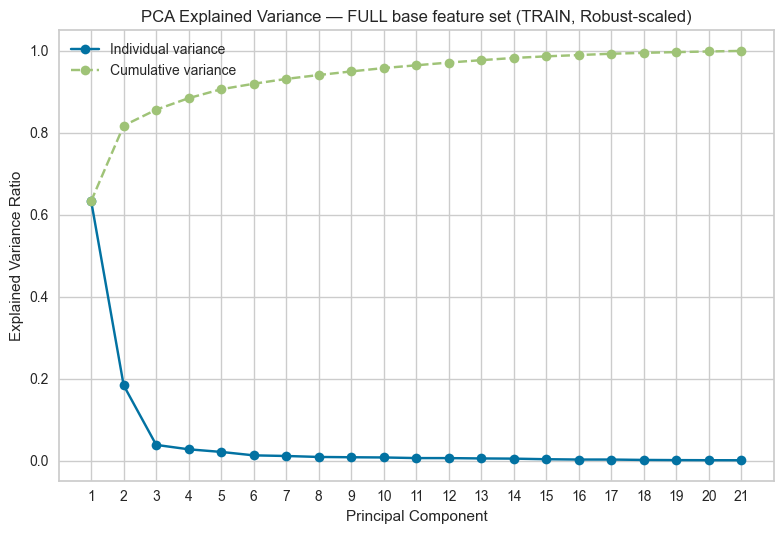

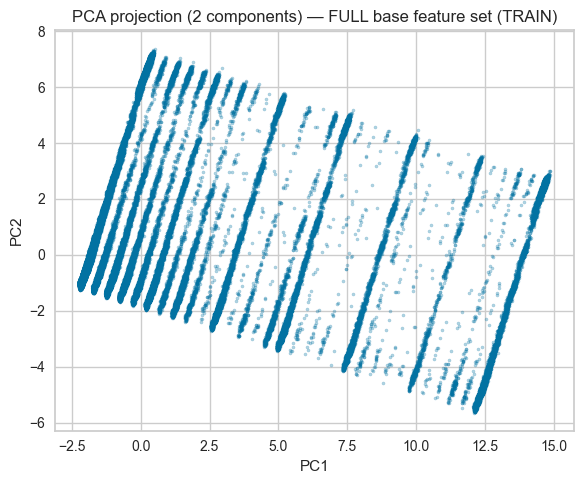

Explained variance (2 PCs): [0.63362336 0.1840459 ]
Cumulative variance (2 PCs): 0.8176692598829344


In [132]:

# --- TRAIN only ---
df_train_full_base = df_base[df_base["split"] == "train"].copy()
X_raw_full_base = df_train_full_base[FULL_COLS_BASE].copy()

print("X_raw_full_base shape:", X_raw_full_base.shape)
print("Missing values:", int(X_raw_full_base.isna().sum().sum()))

# --- Scale ---
scaler_full_base = RobustScaler()
X_scaled_full_base = scaler_full_base.fit_transform(X_raw_full_base)

# --- PCA (inspect) ---
pca_full_base = PCA(random_state=42)
X_pca_full_base = pca_full_base.fit_transform(X_scaled_full_base)

expl = pca_full_base.explained_variance_ratio_
cum = np.cumsum(expl)

print("Cum var @2 PCs:", round(cum[1], 4))
print("Cum var @5 PCs:", round(cum[4], 4))
print("Cum var @10 PCs:", round(cum[9], 4))

# Scree plot
components = np.arange(1, len(expl) + 1)
plt.figure()
plt.plot(components, expl, marker="o", label="Individual variance")
plt.plot(components, cum, marker="o", linestyle="--", label="Cumulative variance")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Explained Variance — FULL base feature set (TRAIN, Robust-scaled)")
plt.xticks(components)
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "pca_explained_variance_full_base.png", dpi=300)
plt.show()

# --- PCA(2) for clustering/visualisation ---
pca2_full_base = PCA(n_components=2, random_state=42)
X_pca2_full_base = pca2_full_base.fit_transform(X_scaled_full_base)

plt.figure(figsize=(6,5))
plt.scatter(X_pca2_full_base[:,0], X_pca2_full_base[:,1], s=5, alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection (2 components) — FULL base feature set (TRAIN)")
plt.tight_layout()
plt.savefig(FIG_DIR / "pca_scatter_full_base_train.png", dpi=300)
plt.show()

print("Explained variance (2 PCs):", pca2_full_base.explained_variance_ratio_)
print("Cumulative variance (2 PCs):", pca2_full_base.explained_variance_ratio_.sum())

k= 2 | inertia=1189276.74
k= 3 | inertia=672215.75
k= 4 | inertia=443647.12
k= 5 | inertia=333126.93
k= 6 | inertia=264191.87
k= 7 | inertia=205060.17
k= 8 | inertia=151897.44
k= 9 | inertia=129986.76
k=10 | inertia=117350.45


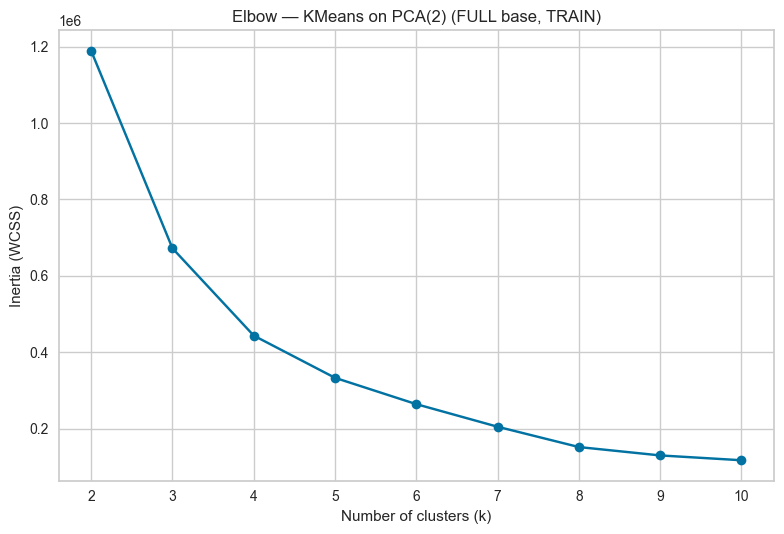

In [133]:
ks = list(range(2, 11))
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca2_full_base)
    inertias.append(km.inertia_)
    print(f"k={k:2d} | inertia={km.inertia_:.2f}")

elbow_full_base_df = pd.DataFrame({"k": ks, "inertia": inertias})

plt.figure()
plt.plot(elbow_full_base_df["k"], elbow_full_base_df["inertia"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow — KMeans on PCA(2) (FULL base, TRAIN)")
plt.tight_layout()
plt.savefig(FIG_DIR / "kmeans_elbow_full_base.png", dpi=300)
plt.show()

k= 2 | silhouette(sample)=0.7620
k= 3 | silhouette(sample)=0.7222
k= 4 | silhouette(sample)=0.7316
k= 5 | silhouette(sample)=0.7220
k= 6 | silhouette(sample)=0.7234
k= 7 | silhouette(sample)=0.6757
k= 8 | silhouette(sample)=0.6703
k= 9 | silhouette(sample)=0.6170
k=10 | silhouette(sample)=0.5773


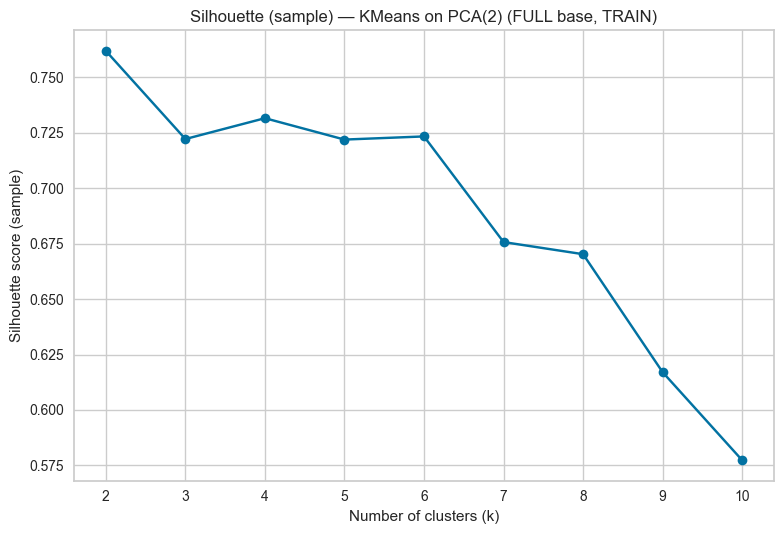

In [134]:


ks = list(range(2, 11))
sil_scores = []

rng = np.random.RandomState(42)
sample_n = 20000 if X_pca2_full_base.shape[0] > 20000 else X_pca2_full_base.shape[0]
idx = rng.choice(X_pca2_full_base.shape[0], size=sample_n, replace=False)
X_samp = X_pca2_full_base[idx]

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca2_full_base)
    sil = silhouette_score(X_samp, km.predict(X_samp))
    sil_scores.append(sil)
    print(f"k={k:2d} | silhouette(sample)={sil:.4f}")

sil_full_base_df = pd.DataFrame({"k": ks, "silhouette_sample": sil_scores})

plt.figure()
plt.plot(sil_full_base_df["k"], sil_full_base_df["silhouette_sample"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score (sample)")
plt.title("Silhouette (sample) — KMeans on PCA(2) (FULL base, TRAIN)")
plt.tight_layout()
plt.savefig(FIG_DIR / "kmeans_silhouette_full_base.png", dpi=300)
plt.show()

K_FULL_BASE: 4
Cluster counts: {np.int32(0): np.int64(123817), np.int32(1): np.int64(10589), np.int32(2): np.int64(14793), np.int32(3): np.int64(11647)}


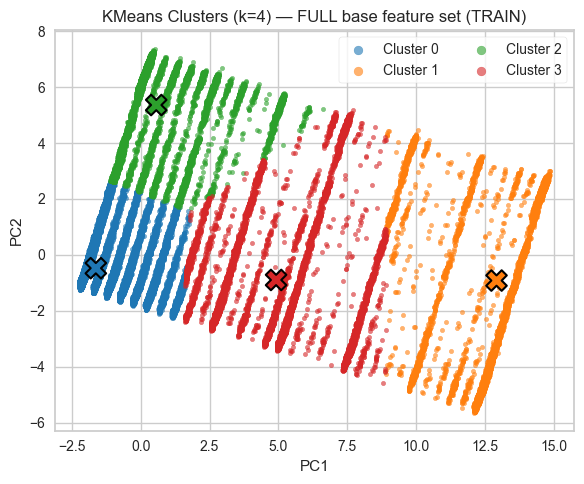

In [135]:
K_FULL_BASE = 4

km_full_base = KMeans(n_clusters=K_FULL_BASE, random_state=42, n_init=10)
clusters_full_base = km_full_base.fit_predict(X_pca2_full_base)

print("K_FULL_BASE:", K_FULL_BASE)
print("Cluster counts:", dict(zip(*np.unique(clusters_full_base, return_counts=True))))

centroids = km_full_base.cluster_centers_
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(6,5))
for k in range(K_FULL_BASE):
    m = clusters_full_base == k
    plt.scatter(
        X_pca2_full_base[m, 0],
        X_pca2_full_base[m, 1],
        s=10, alpha=0.6,
        color=cmap(k),
        label=f"Cluster {k}"
    )

plt.scatter(
    centroids[:, 0], centroids[:, 1],
    marker="X", s=220,
    c=[cmap(i) for i in range(K_FULL_BASE)],
    edgecolor="black", linewidths=1.5
)


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters (k=4) — FULL base feature set (TRAIN)")
plt.legend(markerscale=2, frameon=True, ncol=2)
plt.tight_layout()
plt.savefig(FIG_DIR / "kmeans_clusters_full_base_k4_centroids.png", dpi=300)
plt.show()

In [136]:
# Attach clusters back to train data
df_train_full_base_out = df_train_full_base.copy()
df_train_full_base_out["cluster_full_base"] = clusters_full_base

# Profile ALL base features (means; for binary -> prevalence)
profile_full_base = (
    df_train_full_base_out
    .groupby("cluster_full_base")[FULL_COLS_BASE]
    .mean()
    .round(3)
)

profile_full_base

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex,GenHlth,Age,Education,Income,BMI,MentHlth,PhysHlth
cluster_full_base,,,,,,,,,,,,,,,,,,,,,
0,0.428,0.419,0.958,0.439,0.032,0.083,0.774,0.624,0.806,0.062,0.949,0.066,0.107,0.459,2.346,8.089,5.042,6.151,28.335,0.669,1.120
1,0.548,0.538,0.961,0.609,0.090,0.168,0.555,0.538,0.730,0.068,0.917,0.245,0.475,0.347,3.599,7.591,4.668,4.552,30.234,28.708,15.619
2,0.623,0.552,0.980,0.565,0.105,0.226,0.544,0.612,0.770,0.038,0.956,0.135,0.572,0.417,3.741,9.215,4.700,4.992,30.081,1.421,25.220
3,0.456,0.461,0.960,0.503,0.055,0.109,0.699,0.564,0.776,0.075,0.927,0.180,0.273,0.345,2.984,7.099,4.913,5.412,29.397,13.385,6.717


In [137]:
# Diabetes prevalence (interpretation only)
df_train_full_base_out[TARGET] = df_featA.loc[df_train_full_base_out.index, TARGET]

diabetes_full_base = (
    df_train_full_base_out
    .groupby("cluster_full_base")[TARGET]
    .mean()
    .round(3)
)

diabetes_full_base

cluster_full_base
0    0.148
1    0.266
2    0.304
3    0.185
Name: Diabetes_binary, dtype: float64

**Clustering on engineered dataset for comparison**

X_raw_full_featA shape: (160846, 26)
Missing values: 0
Cum var @2 PCs: 0.7945
Cum var @5 PCs: 0.8905
Cum var @10 PCs: 0.9491


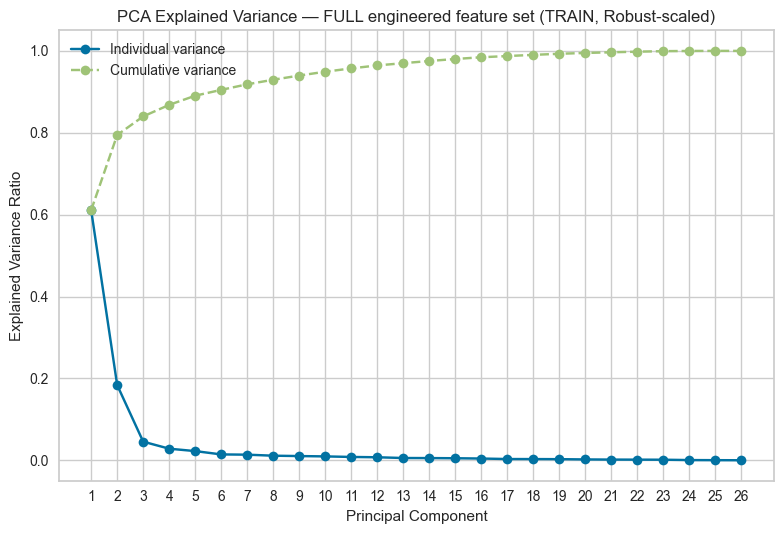

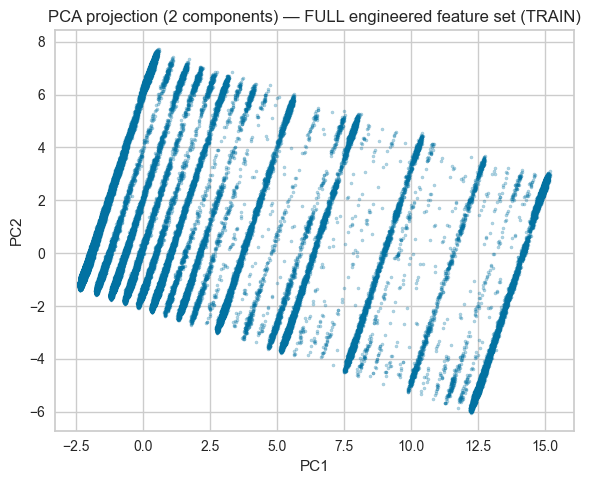

Explained variance (2 PCs): [0.61088391 0.18363111]
Cumulative variance (2 PCs): 0.794515021207879


In [138]:
# --- TRAIN only ---
df_train_full_featA = df_featA[df_featA["split"] == "train"].copy()
X_raw_full_featA = df_train_full_featA[FULL_COLS_FEATA].copy()

print("X_raw_full_featA shape:", X_raw_full_featA.shape)
print("Missing values:", int(X_raw_full_featA.isna().sum().sum()))

# --- Scale ---
scaler_full_featA = RobustScaler()
X_scaled_full_featA = scaler_full_featA.fit_transform(X_raw_full_featA)

# --- PCA (inspect) ---
pca_full_featA = PCA(random_state=42)
X_pca_full_featA = pca_full_featA.fit_transform(X_scaled_full_featA)

expl = pca_full_featA.explained_variance_ratio_
cum = np.cumsum(expl)

print("Cum var @2 PCs:", round(cum[1], 4))
print("Cum var @5 PCs:", round(cum[4], 4))
print("Cum var @10 PCs:", round(cum[9], 4))

# Scree plot
components = np.arange(1, len(expl) + 1)
plt.figure()
plt.plot(components, expl, marker="o", label="Individual variance")
plt.plot(components, cum, marker="o", linestyle="--", label="Cumulative variance")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Explained Variance — FULL engineered feature set (TRAIN, Robust-scaled)")
plt.xticks(components)
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "pca_explained_variance_full_featA.png", dpi=300)
plt.show()

# --- PCA(2) for clustering/visualisation ---
pca2_full_featA = PCA(n_components=2, random_state=42)
X_pca2_full_featA = pca2_full_featA.fit_transform(X_scaled_full_featA)

plt.figure(figsize=(6,5))
plt.scatter(X_pca2_full_featA[:,0], X_pca2_full_featA[:,1], s=5, alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection (2 components) — FULL engineered feature set (TRAIN)")
plt.tight_layout()
plt.savefig(FIG_DIR / "pca_scatter_full_featA_train.png", dpi=300)
plt.show()

print("Explained variance (2 PCs):", pca2_full_featA.explained_variance_ratio_)
print("Cumulative variance (2 PCs):", pca2_full_featA.explained_variance_ratio_.sum())

k= 2 | inertia=1302643.61
k= 3 | inertia=742175.67
k= 4 | inertia=502225.36
k= 5 | inertia=379003.58
k= 6 | inertia=305210.00
k= 7 | inertia=236161.11
k= 8 | inertia=177896.72
k= 9 | inertia=151117.85
k=10 | inertia=131368.33


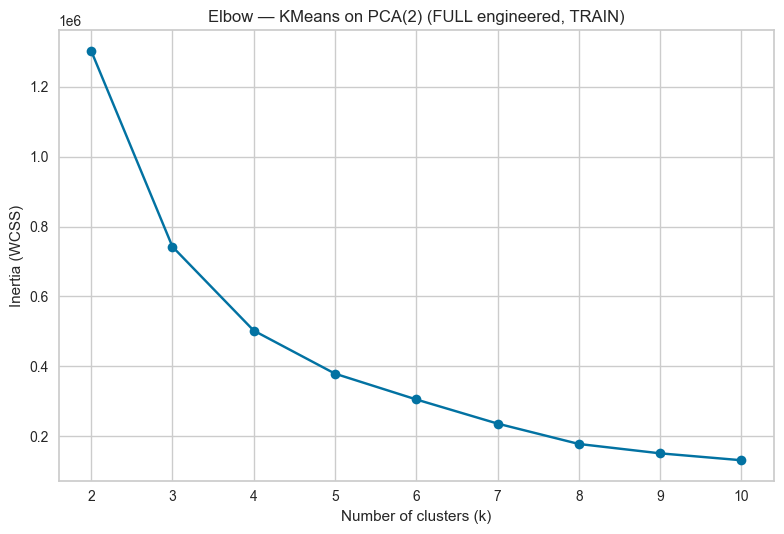

In [139]:
ks = list(range(2, 11))
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca2_full_featA)
    inertias.append(km.inertia_)
    print(f"k={k:2d} | inertia={km.inertia_:.2f}")

elbow_full_featA_df = pd.DataFrame({"k": ks, "inertia": inertias})

plt.figure()
plt.plot(elbow_full_featA_df["k"], elbow_full_featA_df["inertia"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow — KMeans on PCA(2) (FULL engineered, TRAIN)")
plt.tight_layout()
plt.savefig(FIG_DIR / "kmeans_elbow_full_featA.png", dpi=300)
plt.show()

k= 2 | silhouette(sample)=0.7514
k= 3 | silhouette(sample)=0.7049
k= 4 | silhouette(sample)=0.7130
k= 5 | silhouette(sample)=0.6850
k= 6 | silhouette(sample)=0.6292
k= 7 | silhouette(sample)=0.6314
k= 8 | silhouette(sample)=0.6448
k= 9 | silhouette(sample)=0.6131
k=10 | silhouette(sample)=0.5861


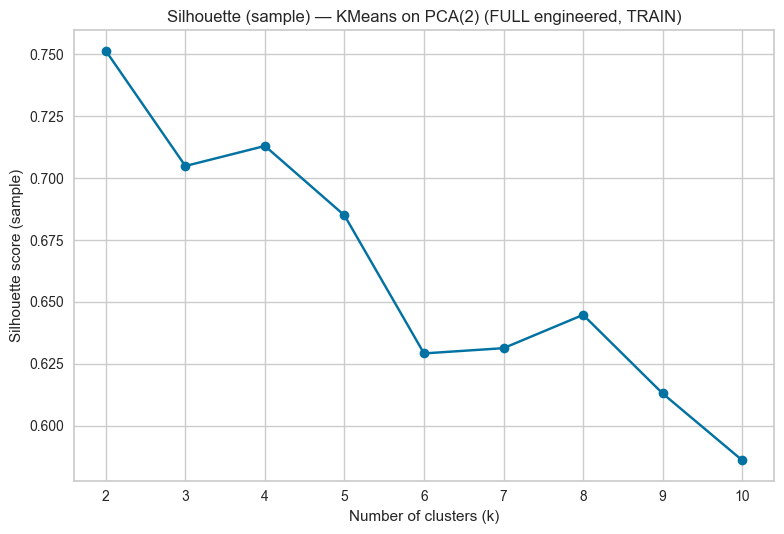

In [140]:
ks = list(range(2, 11))
sil_scores = []

rng = np.random.RandomState(42)
sample_n = 20000 if X_pca2_full_featA.shape[0] > 20000 else X_pca2_full_featA.shape[0]
idx = rng.choice(X_pca2_full_featA.shape[0], size=sample_n, replace=False)
X_samp = X_pca2_full_featA[idx]

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca2_full_featA)
    sil = silhouette_score(X_samp, km.predict(X_samp))
    sil_scores.append(sil)
    print(f"k={k:2d} | silhouette(sample)={sil:.4f}")

sil_full_featA_df = pd.DataFrame({"k": ks, "silhouette_sample": sil_scores})

plt.figure()
plt.plot(sil_full_featA_df["k"], sil_full_featA_df["silhouette_sample"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score (sample)")
plt.title("Silhouette (sample) — KMeans on PCA(2) (FULL engineered, TRAIN)")
plt.tight_layout()
plt.savefig(FIG_DIR / "kmeans_silhouette_full_featA.png", dpi=300)
plt.show()

K_FULL_FEATA: 4
Cluster counts: {np.int32(0): np.int64(12777), np.int32(1): np.int64(121897), np.int32(2): np.int64(10827), np.int32(3): np.int64(15345)}


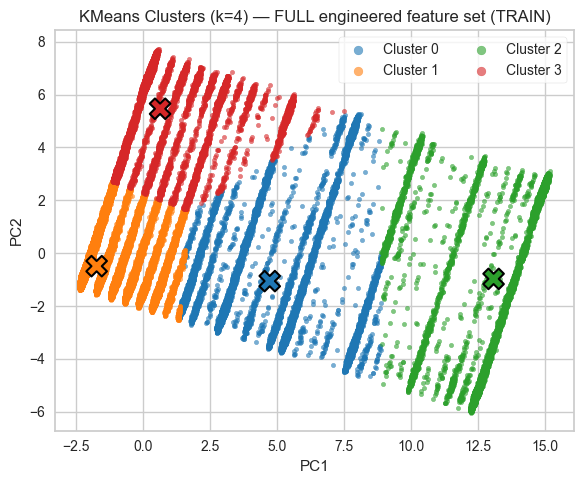

In [141]:
K_FULL_FEATA = 4

km_full_featA = KMeans(n_clusters=K_FULL_FEATA, random_state=42, n_init=10)
clusters_full_featA = km_full_featA.fit_predict(X_pca2_full_featA)

print("K_FULL_FEATA:", K_FULL_FEATA)
print("Cluster counts:", dict(zip(*np.unique(clusters_full_featA, return_counts=True))))

centroids = km_full_featA.cluster_centers_
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(6,5))
for k in range(K_FULL_FEATA):
    m = clusters_full_featA == k
    plt.scatter(
        X_pca2_full_featA[m, 0],
        X_pca2_full_featA[m, 1],
        s=10, alpha=0.6,
        color=cmap(k),
        label=f"Cluster {k}"
    )

plt.scatter(
    centroids[:, 0], centroids[:, 1],
    marker="X", s=220,
    c=[cmap(i) for i in range(K_FULL_FEATA)],
    edgecolor="black", linewidths=1.5
)


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters (k=4) — FULL engineered feature set (TRAIN)")
plt.legend(markerscale=2, frameon=True, ncol=2)
plt.tight_layout()
plt.savefig(FIG_DIR / "kmeans_clusters_full_featA_k4_centroids.png", dpi=300)
plt.show()

In [142]:
# Attach clusters back to train data
df_train_full_featA_out = df_train_full_featA.copy()
df_train_full_featA_out["cluster_full_featA"] = clusters_full_featA

# Profile ALL engineered features (means)
profile_full_featA = (
    df_train_full_featA_out
    .groupby("cluster_full_featA")[FULL_COLS_FEATA]
    .mean()
    .round(3)
)

profile_full_featA

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex,GenHlth,Age,Education,Income,BMI,MentHlth,PhysHlth,RiskFactorCount,BMI_PhysActivity,Age_HighBP,Log1p_MentHlth,Log1p_PhysHlth
cluster_full_featA,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.440,0.448,0.959,0.495,0.051,0.100,0.709,0.567,0.779,0.076,0.928,0.175,0.252,0.343,2.921,6.996,4.934,5.479,29.270,12.571,6.009,1.786,20.275,3.642,2.563,1.209
1,0.428,0.418,0.957,0.439,0.032,0.082,0.775,0.624,0.806,0.062,0.949,0.065,0.105,0.460,2.340,8.103,5.043,6.159,28.327,0.598,1.067,1.503,21.674,3.996,0.268,0.398
2,0.549,0.539,0.962,0.609,0.090,0.170,0.555,0.538,0.731,0.067,0.916,0.245,0.476,0.346,3.602,7.593,4.666,4.545,30.243,28.518,15.598,2.433,16.324,4.579,3.378,2.148
3,0.628,0.557,0.980,0.567,0.106,0.229,0.546,0.611,0.771,0.038,0.956,0.134,0.570,0.416,3.720,9.232,4.702,4.997,30.074,1.399,24.741,2.657,15.995,6.121,0.481,3.205


In [143]:
# Diabetes prevalence (interpretation only)
df_train_full_featA_out[TARGET] = df_featA.loc[df_train_full_featA_out.index, TARGET]

diabetes_full_featA = (
    df_train_full_featA_out
    .groupby("cluster_full_featA")[TARGET]
    .mean()
    .round(3)
)

diabetes_full_featA

cluster_full_featA
0    0.177
1    0.148
2    0.265
3    0.305
Name: Diabetes_binary, dtype: float64

In [144]:
# Diabetes prevalence (already computed)
base_prev = diabetes_full_base.rename("diabetes_prev_base")
featA_prev = diabetes_full_featA.rename("diabetes_prev_featA")

# Add a risk band label to make comparison human-readable
def risk_band(p):
    if p < 0.16: return "Low"
    if p < 0.22: return "Low–Mid"
    if p < 0.29: return "Mid–High"
    return "High"

base_tbl = base_prev.to_frame()
base_tbl["risk_band"] = base_tbl["diabetes_prev_base"].apply(risk_band)

featA_tbl = featA_prev.to_frame()
featA_tbl["risk_band"] = featA_tbl["diabetes_prev_featA"].apply(risk_band)

# Cluster sizes
base_sizes = pd.Series(df_train_full_base_out["cluster_full_base"].value_counts(), name="n_base")
featA_sizes = pd.Series(df_train_full_featA_out["cluster_full_featA"].value_counts(), name="n_featA")

# Combine
summary_base = base_tbl.join(base_sizes, how="left")
summary_featA = featA_tbl.join(featA_sizes, how="left")

display(summary_base.sort_values("diabetes_prev_base"))
display(summary_featA.sort_values("diabetes_prev_featA"))

,diabetes_prev_base,risk_band,n_base
cluster_full_base,,,
0,0.148,Low,123817
3,0.185,Low–Mid,11647
1,0.266,Mid–High,10589
2,0.304,High,14793


,diabetes_prev_featA,risk_band,n_featA
cluster_full_featA,,,
1,0.148,Low,121897
0,0.177,Low–Mid,12777
2,0.265,Mid–High,10827
3,0.305,High,15345
